In [1]:
# Import all dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

### Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(10))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()   
        
#         original arguments
#         hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)

#         reduced the n_features
#         hv = HashingVectorizer(n_features=2 ** 10, alternate_sign=False) 
        
#         add english dictionary
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False, stop_words='english') 
    
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()

#  TfidfTransformer(sublinear_tf=True)
#         transformer = TfidfTransformer(sublinear_tf=True)

        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
#         original arguments
        sc = StandardScaler(with_mean=False)
    
#     added with std=False
#         sc = StandardScaler(with_mean=False, std=False)
    
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

### Create training and test sets from function 
Test set is using 25

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# testing set uses 25: 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='../data/moviereviews_train.tsv', my_random_seed=25)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
        id  sentiment                                             review
0   5814_8          1  With all this stuff going down at the moment w...
1   2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2   7759_3          0  The film starts with a manager (Nicholas Bell)...
3   3630_4          0  It must be assumed that those who praised this...
4   9495_8          1  Superbly trashy and wondrously unpretentious 8...
5   8196_8          1  I dont know why people think this is such a ba...
6   7166_2          0  This movie could have been very good, but come...
7  10633_1          0  I watched this video at a friend's house. I'm ...
8    319_1          0  A friend of mine bought this film for £1, and ...
9  8713_10  

### Fit (and tune) Various Models

#### MODEL: ordinary least squares

In [5]:
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 4260, 'TN': 5743, 'FP': 4280, 'FN': 5717, 'Accuracy': 0.50015, 'Precision': 0.49882903981264637, 'Recall': 0.4269820587350907, 'desc': 'ols_train'}


#### MODEL: SVM, linear

In [6]:
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


#### MODEL: logistic regression

In [7]:
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


#### MODEL: Naive Bayes

In [8]:
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9565, 'TN': 9865, 'FP': 158, 'FN': 412, 'Accuracy': 0.9715, 'Precision': 0.9837498714388563, 'Recall': 0.958705021549564, 'desc': 'nbs_train'}


#### MODEL: Perceptron

In [9]:
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


#### MODEL: Ridge Regression Classifier

In [10]:
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


#### MODEL: Random Forest Classifier

In [11]:
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 9977, 'Neg': 10023, 'TP': 6458, 'TN': 5904, 'FP': 4119, 'FN': 3519, 'Accuracy': 0.6181, 'Precision': 0.6105701049446913, 'Recall': 0.6472887641575624, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

In [12]:
def create_ROC_plot():
    fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

    for fit in fits:
        plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
                 fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
        plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
                 fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    plt.axis([0, 1, 0, 1])
    plt.title('ROC plot: train set')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    return plt.show()

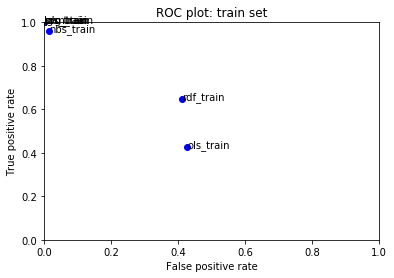

In [13]:
create_ROC_plot()


### Looking at reviews based on their classification
Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well.

In [14]:
ols_predictions = ols.predict(X_train)

In [15]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')

Examples of false positives:
199
Wow-this one sucks. I'm gonna sum it up as quickly as possible. <br /><br />A count invites 4 naive sluts back to his castle. A bunch of nothing happens for a long time. Some lame and un-erotic soft-core sex scenes happen. Some girls get their heads cut off (off-screen)-The End.<br /><br />The only things going for this one are the decent looking sets and costumes, some bad dubbing which leads to some unintentionally funny dialogue, and a few brief nudie shots. And believe me-those things are not enough to redeem the 90-minutes of tedium that this film is. In fact-the best part is the tacked on beginning from the distributor that features some slutty goth chicks covered in blood and showing their tits-and again-this is definitely not worth the price of admission for this garbage. As everyone else has noted- the title of the film is completely nonsensical-as there's absolutely no bloodsucking, nor dancing of any sort in the film at all. It may as well ha

2672
If this documentary had not been made by the famous French director, Louis Malle, I probably would have turned it off after the first 15 minutes, as it was an incredibly dull look at a very ordinary Midwestern American town in 1979. This is not exactly my idea of a fun topic and the film footage closely resembled a collection of home movies. Considering I didn't know any of these people, it was even less interesting.<br /><br />Because it was a rather dull slice of life style documentary, I wondered while watching what was the message they were trying to convey? Perhaps it was that values aren't as conservative as you might think--this was an underlying message through many of the vignettes (such as the Republicans whose son was a draft resister as well as the man and lady who thought sex outside of marriage was just fine). Or, perhaps the meaning was that there was a lot of bigotry underlying the nice home town--as several ugly ideas such as blaming Jews for financial conspiracie

5036
Images are great and reflect well the landscapes of Canada. The story was, on the other side, quite boring; To my eyes it was a love story in the woods just like Titanic was a love story on a boat. I did not feel that Grey Owl was great environmentalist. I usually like Lord Attenborough but this one was ... bad.
* * * * * * * * * 
5085
Average (and surprisingly tame) Fulci giallo which means it's still quite bad by normal standards, but redeemed by its solid build-up and some nice touches such as a neat time twist on the issues of visions and clairvoyance.<br /><br />The genre's well-known weaknesses are in full gear: banal dialogue, wooden acting, illogical plot points. And the finale goes on much too long, while the denouement proves to be a rather lame or shall I say: limp affair.<br /><br />Fulci's ironic handling of giallo norms is amusing, though. Yellow clues wherever you look.<br /><br />3 out of 10 limping killers
* * * * * * * * * 
5128
What starts out as an interesting 

7698
Hey HULU.com is playing the Elvira late night horror show on their site and this movie is their under the Name Monsteroid, good fun to watch Elvira comment on this Crappy movie ....Have Fun with bad movies. Anyways this movie really has very little value other than to see how bad the 70's were for horror flicks Bad Effects, Bad Dialog, just bad movie making. Avoid this unless you want to laugh at it. While you are at HULU check out the other movies that are their right now there is 10 episodes and some are pretty decent movies with good plots and production and you can watch a lot of them in 480p as long as you have a decent speed connection.
* * * * * * * * * 
7731
the IMDb guidelines state that you have to declare if your comments contain 'spoilers'. <br /><br />well, this whole film is something of a spoiler... a cautionary tale that glorifies what it cautions against, a tale of lost youth that doesn't know where it itself is going.<br /><br />i just saw this at the tribeca fil

10312
turned out to be another failed attempt by the laughable sci-fi channel. i am not sure who wrote the script, and interpreted the poem, but i am sure it was by some 17 year old teen who thought it would be awesome to a have a scoped crossbow in the movie. AAAAAAAH! when i saw that part, I lost all hope. Then...they set off for heorot in a what looks to be the ship that Christopher Columbus sailed in! when they reach Heorot, (which is supposed to be a Norse mead hall) the sci-fi group of idiots decided to make heorot look like a big stone castle. when i saw that part.. i wanted to scream. i really wanted this movie to be good, but sci-fi has yet to produce a good movie, so i don't know why i got my hopes up. Oh..and Grendel and his mother, are stupid also. (this comment is off topic about \Grendel\")If anyone from the sci-fi channel is reading this..here is some good advice. NOT EVERY MOVIE YOU MAKE HAS TO BE ABOUT A BIG MONSTER THAT CAN RIP PEOPLE IN HALF, THATS NOT WHAT SCIENCE F

12775
I really tried to like this movie but in the end it just didn't work for me. I have seen most of Kitamura's output and have found it to be very variable. Alive, like all of his films has an interesting plot, some nifty sequences and a fair amount of creativity. However, these qualities are in painfully short supply in Alive. The plot is cool if not all that original and could have made for a pretty ace film. Unfortunately, the pacing is painfully slow and the film takes an age to get going, before reaching fairly predictable places. The action is just about passable, with the final fight pretty cool, and the earlier one about OK. The earlier one is also marred by overspeedy camera-work, making for less coherency. There are some neat visual effects and some interesting ideas floating around in the dialogue but the film still drags badly. The characters are neither well fleshed out nor well acted and the setting and general color scheme is drab and boring. The film is not completel

14803
I'll have to add dissenting comment here. Various reviews I have read compared this movie to the likes of those by Wong Kar Wai or Hou Hsiao-hsien. i.e. one of the admirable flotilla of mandarin goodies that have come our way in recent years. Unfortunately this isn't quite accurate. The film plays out rather like a film school graduate's attempt to emulate these masters. All the pieces are there - the beautiful backdrop, the vaguely minimalist dialogue, the slow swaying camerawork, and male leads, in particular, who spend a fair whack of time sitting around being contemplative. Sounds good but unfortunately nothing is up to par. The dialogue is leaden. The acting is generally unable to lift the characters above type; the married couple and the little sister are particularly poor and uninvolving. Unfortunately when mediocre character acting is combined with a classical \Chekovian\" (i.e. very predictable) plot, the results are at best tedious and at worst painful. I couldn't help 

17010
Angels who got a little icky were banned from heaven and now reside in a British forest where they seduce and chop up teens. Talk about high concept. On the plus side this little mother gives us Tom Savini, but since his acting range is limited to two minutes screen-time, his five minute presence seems a tad long. The angels run around the forest naked for the most part of the movie, but though they might have the body of an angel, their faces sure look like Joan Rivers on a bad day. Mediocre acting and amateurish gore-effects don't help and the night scenes fatally recall Paris Hilton's most famous movie. So bad that it is REALLY bad.
* * * * * * * * * 
17028
Think of a no-budget version of China Syndrome being directed by a film student who idolizes John Woo and you'll get 'Power Play.' The idea was good, but the execution, acting, and dialog absolutely killed it, not to mention ridiculous amounts of violence and disaster sequences that was used to compensate for lack of substa

19351
I remember watching this film back in 86' when it first came out & what an awful film. The acting was atrocious the plot was so flimsy it would or is that should have blew away in a breath of wind. I think it put me to sleep on more than one occasion & i was not tired that i remember. Please avoid at all costs better still have all your teeth taken out with no anaesthetic cos that would be more entertaining. It's just a pity i couldn't give it a zero or a negative score. I wish i had not wasted my money getting this one from the video shop all i can say was that the tape it was on was still brand new practically hardly surprising as the film was so poor. If i remember right i sat & watched it with a girl i really wanted to go out with & the fact she was sat next to me was still not enough to keep me awake thats how bad this film was.
* * * * * * * * * 
19365
When I was younger, I thought the first film was really good in childhood, so I decided to see the sequel. This is an examp

## Look at performance on the test set

#### MODEL: ordinary least squares

In [16]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 989, 'TN': 1524, 'FP': 953, 'FN': 1534, 'Accuracy': 0.5026, 'Precision': 0.5092687950566427, 'Recall': 0.3919936583432422, 'desc': 'ols_test'}


#### MODEL: SVM, linear

In [17]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2125, 'TN': 2085, 'FP': 392, 'FN': 398, 'Accuracy': 0.842, 'Precision': 0.844259038537942, 'Recall': 0.8422512881490289, 'desc': 'svm_test'}


#### MODEL: logistic regression

In [18]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2139, 'TN': 2064, 'FP': 413, 'FN': 384, 'Accuracy': 0.8406, 'Precision': 0.838166144200627, 'Recall': 0.8478002378121284, 'desc': 'lgs_test'}


#### MODEL: Naive Bayes

In [19]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 1865, 'TN': 1833, 'FP': 644, 'FN': 658, 'Accuracy': 0.7396, 'Precision': 0.7433240334794738, 'Recall': 0.7391993658343242, 'desc': 'nbs_test'}


#### MODEL: Perceptron

In [20]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2101, 'TN': 2061, 'FP': 416, 'FN': 422, 'Accuracy': 0.8324, 'Precision': 0.8347238776321018, 'Recall': 0.832738803012287, 'desc': 'prc_test'}


#### MODEL: Ridge Regression Classifier

In [21]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2182, 'TN': 2060, 'FP': 417, 'FN': 341, 'Accuracy': 0.8484, 'Precision': 0.8395536744901886, 'Recall': 0.8648434403487911, 'desc': 'rdg_test'}


#### MODEL: Random Forest Classifier

In [22]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 1617, 'TN': 1513, 'FP': 964, 'FN': 906, 'Accuracy': 0.626, 'Precision': 0.6265013560635413, 'Recall': 0.6409036860879905, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

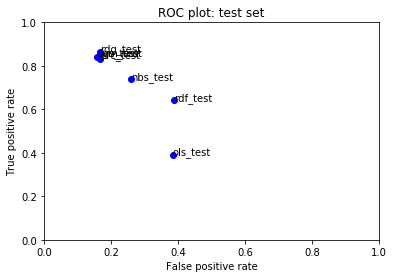

In [23]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


# Iteration

### Strater code performance graph (before intervention):

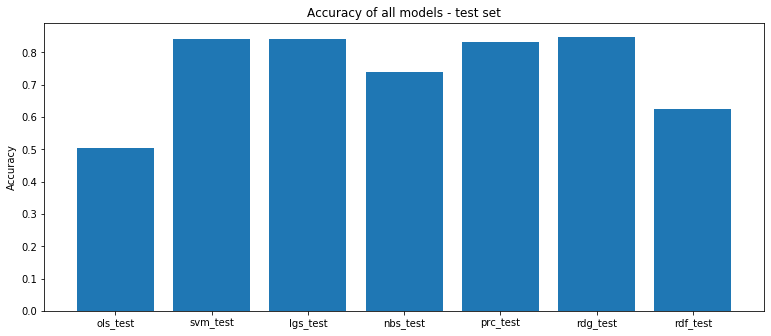

In [24]:
# Bar chart comparing the performance of the models on the test set after changes were introduced
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

accuracy = []
description = []

for fit in fits:
    accuracy.append(fit.performance_measures['Accuracy'])
#     print(fit.performance_measures['Accuracy'], fit.performance_measures['desc'])
    description.append(fit.performance_measures['desc'])

# plot the performances as a bar chart
fig = plt.figure(figsize=[10, 4])
ax = fig.add_axes([0,0,1,1])
plt.bar(description, accuracy, align="center")
plt.ylabel('Accuracy')
plt.title('Accuracy of all models - test set')

plt.show()

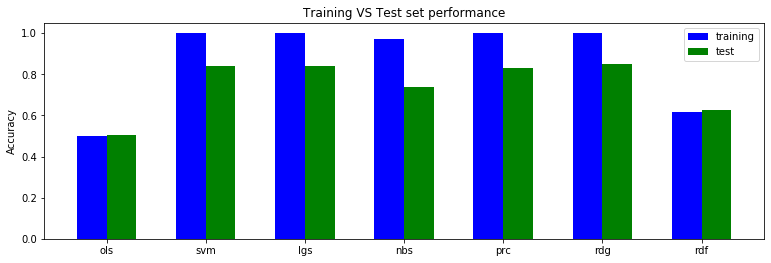

In [25]:
# Grouped bar chart comparing training and test set after changes were introduced
fits_train = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]
fits_test = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

accuracy_train = []
description = []
for fit in fits_train:
    accuracy_train.append(fit.performance_measures['Accuracy'])
    fit.performance_measures['desc'] = fit.performance_measures['desc'].split('_')[0]
    description.append(fit.performance_measures['desc'])
    
accuracy_test = []
for fit in fits_test:
    accuracy_test.append(fit.performance_measures['Accuracy'])

width = 0.3
x = np.arange(len(description))

fig = plt.figure(figsize=[10, 3])
ax = fig.add_axes([0,0,1,1])

ax.bar(x, accuracy_train, color='b', width=width, label="training")
ax.bar(x + width, accuracy_test, color='g', width=width, label="test")

ax.set_ylabel('Accuracy')
ax.set_title('Training VS Test set performance')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(description)
ax.legend()

plt.show()
